# 14. 프로젝트 : 폐렴 진단기 성능개선

좀전까지 우리는 대략 80% 정도의 정확도를 가진 X-RAY 사진 판독 폐렴 진단기를 만들어 보았습니다.

하지만 숙련된 의사분들은 90% 이상에 도달한다고 하니, 좀더 분발해야겠죠?

그렇다면 우리는 좀전까지의 실습 과정을 되짚어보면서, 어떤 점을 좀더 개선해볼 수 있을지 따져 보고 스스로 개선해 가면서 좀더 성능을 향상시켜 보려고 합니다.

## 루브릭

|평가문항	|상세기준|
|:--------|:----------|
|1. 의료영상을 처리하는 CNN 기반 딥러닝 모델이 잘 구현되었다.|모델 학습이 안정적으로 수렴하는 것을 시각화를 통해 확인하였다.|
|2. 데이터 준비, 모델구성 등의 과정의 다양한 실험이 체계적으로 수행되었다.|regularization, augmentation 등의 기법의 사용 여부에 따른 모델 성능 측정이 ablation study 형태로 체계적으로 수행되었다.|
|3. 실습코드를 잘 개선하여 폐렴 검출 정확도가 추가로 향상되었다.|Accuracy 기준 85%에 도달하였다.|

## Step 1. 실험환경 Set-up

거의 바꿔볼 수 있을게 없을 것 같지만, Batch size, Epoch 등을 변경해볼 수 있을 것입니다.

In [1]:
import re                          # 정규표현식 관련된 작업에 필요한 패키지
import os                          # I/O 관련된 작업에 필요한 패키지 
import pandas as pd                # 데이터 전처리 관련된 작업에 필요한 패키지
import numpy as np                 # 데이터 array 작업에 필요한 패키지
import tensorflow as tf            # 딥러닝 관련된 작업에 필요한 패키지
import matplotlib.pyplot as plt    # 데이터 시각화에 관련된 작업에 필요한 패키지
from sklearn.model_selection import train_test_split  # 데이터 전처리에 필요한 패키지

print("✅")

✅


In [2]:
# 필요한 만큼 메모리를 런타임에 할당하는 방법 (https://inpages.tistory.com/155)
def init_gpu():
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
        # Currently, memory growth needs to be the same across GPUs
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
                logical_gpus = tf.config.experimental.list_logical_devices('GPU')
                print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        except RuntimeError as e:
        # Memory growth must be set before GPUs have been 
             print(e)
init_gpu()

1 Physical GPUs, 1 Logical GPUs


In [3]:
# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [72]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE

# 데이터 ROOT 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')

# BATCH_SIZE 변수
BATCH_SIZE = 64           # 16 --> 64 --> 128

# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# EPOCH 크기 변수
EPOCHS = 25               # 25 --> 50 --> 100

print(ROOT_PATH)

/home/aiffel-d34j/aiffel


## Step 2. 데이터 준비하기

원본 데이터를 가져와서 전처리 및 배치 구성을 진행합니다.
의료영상 이미지의 특성상 데이터는 언제나 충분하지 않습니다. 이를 극복할 수 있는 방법을 고민해 봅시다.

이전 실습에서 고려하지 않았던 **augmentation 기법**을 고려해 볼 수 있을 것입니다. 그러나 의료영상인 경우, 일반적인 이미지처리에서 사용하는 augmentation들이 항상 도움이 된다고 말할 수 없습니다. 특히 X-RAY 같은 의료영상의 특성상, 육안으로도 구분하기 어려운 미묘한 차이에 더해진 노이즈 등 부수효과가 오히려 방해를 줄 수도 있기 때문입니다.
그래서 augmentation 도입은 신중해야 합니다.

만약 예를 들어 **좌우반전** 정도의 augmentation만 도입한다고 한다면 다음과 같이 진행될 것입니다.

In [5]:
# 데이터 가져오기
train_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/train/*/*'))
test_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/test/*/*'))
val_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/val/*/*'))

print('train data:',len(train_filenames))        # 1341 + 3875
print('test data:',len(test_filenames))          # 234 + 390
print('validation data:', len(val_filenames))    # 8 + 8

train data: 5216
test data: 624
validation data: 16


In [6]:
# train과 val에 있는 데이터를 한 곳에 모으기
filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/train/*/*'))
filenames.extend(tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/val/*/*')))

# train, test(val) dataset으로 분할. test_size에 0.2는 20%롤 의미함.
train_filenames, val_filenames = train_test_split(filenames, test_size=0.2, random_state=2021, shuffle=True)

print('new_train data :',len(train_filenames))
print('new_validation data :',len(val_filenames))

new_train data : 4185
new_validation data : 1047


* `tf.io.gfile.glob(pattern)` : 주어진 패턴과 일치하는 파일 목록을 반환
  - '*': matches any sequence of non-'/' characters
  - '?': matches a single non-'/' character
  
  
* `train_test_split(arrays, test_size, train_size, random_state, shuffle, stratify)` : 데이터 분할
  - **Parameter**
    - arrays : 분할시킬 데이터를 입력 (Python list, Numpy array, Pandas dataframe 등..)
    - test_size : 테스트 데이터셋의 비율(float)이나 갯수(int) (default = 0.25)
    - train_size : 학습 데이터셋의 비율(float)이나 갯수(int) (default = test_size의 나머지)
    - random_state : 데이터 분할시 셔플이 이루어지는데 이를 위한 시드값 (int나 RandomState로 입력)
    - shuffle : 셔플여부설정 (default = True)
    - stratify : 지정한 Data의 비율을 유지한다. 
      - 예를 들어, Label Set인 Y가 25%의 0과 75%의 1로 이루어진 Binary Set일 때, 
      - stratify=Y로 설정하면 나누어진 데이터셋들도 0과 1을 각각 25%, 75%로 유지한 채 분할된다.
  - **Return**
    - X_train, X_test, Y_train, Y_test : arrays에 데이터와 레이블을 둘 다 넣었을 경우의 반환이며, 데이터와 레이블의 순서쌍은 유지된다.
    - X_train, X_test : arrays에 레이블 없이 데이터만 넣었을 경우의 반환

  - [참고](http://blog.naver.com/PostView.nhn?blogId=siniphia&logNo=221396370872)

In [7]:
# train 데이터 안에 정상 이미지 수와 폐렴 이미지 수 확인
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print("Normal images count in training set: " + str(COUNT_NORMAL))

COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print("Pneumonia images count in training set: " + str(COUNT_PNEUMONIA))

Normal images count in training set: 1081
Pneumonia images count in training set: 3104


### 데이터 셋 만들기

In [8]:
# 배치처리 작업을 보다 효율적으로 할 수 있도록 데이터셋 만들기
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

print("✅")

✅


* 만약 모든 데이터가 메모리에 존재한다면, 
  - 이들로부터 Dataset을 만드는 가장 간단한 방법은 
    - Dataset.from_tensor_slices()를 사용하여 tf.Tensor로 변환하는 것
* `.from_tensor_slices(tensors)` : numpy array나 list를 tensor dataset으로 변환

In [9]:
# Train 데이터 셋, validation 데이터 셋 갯수 확인
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print("Training images count: " + str(TRAIN_IMG_COUNT))

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print("Validating images count: " + str(VAL_IMG_COUNT))

Training images count: 4185
Validating images count: 1047


* `tf.data.experimental.cardinality(dataset)` : 데이터 세트의 카디널리티(집합 또는 그룹의 요소 수)를 반환


* `.numpy()` : 텐서를 넘파이 배열로 변환
  - tf.Tensor는 GPU 메모리에 저장될 수 있고, 
  - 넘파이 배열은 항상 호스트 메모리에 저장

In [10]:
# 라벨 이름 확인
CLASS_NAMES = np.array([str(tf.strings.split(item, os.path.sep)[-1].numpy())[2:-1]
                        for item in tf.io.gfile.glob(str(ROOT_PATH + "/chest_xray/train/*"))])
print(CLASS_NAMES)

['NORMAL' 'PNEUMONIA']


* `tf.strings.split(file_path, os.path.sep)` : 경로를 경로 구성 요소 목록으로 변환


* `os.path.sep` : 파일 경로를 리스트로 얻기, [참고](https://itmining.tistory.com/122)

In [11]:
# 라벨 데이터를 만들어 주는 함수
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)를 리턴하게 합니다.
  
print("✅")

✅


### 이미지 크기 축소

In [12]:
# 축소된 이미지 만들기
def decode_img(img):
  # 이미지를 uint8 tensor로 바꾼다.
  img = tf.image.decode_jpeg(img, channels=3)
    
  # img를 범위 [0,1]의 float32 데이터 타입으로 바꾼다.
  img = tf.image.convert_image_dtype(img, tf.float32)
    
  # img의 이미지 사이즈를 IMAGE_SIZE에서 지정한 사이즈로 수정한다.
  return tf.image.resize(img, IMAGE_SIZE)               # [180, 180]

# 이미지 파일 읽고 크기 축소 시키기
def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label
  
print("✅")

✅


* `tf.image.decode_jpeg()` : JPEG로 인코딩 된 이미지를 uint8 텐서로 디코딩, [참고](https://www.tensorflow.org/api_docs/python/tf/io/decode_jpeg?hl=ko)


* `tf.image.convert_image_dtype()` : 이미지를 dtype으로 변환하고 필요한 경우 값을 조정, [참고](https://www.tensorflow.org/api_docs/python/tf/image/convert_image_dtype)


* `tf.image.resize()` : 지정된 방법을 사용하여 이미지 크기를 조정, [참고](https://www.tensorflow.org/api_docs/python/tf/image/resize)


* `tf.io.read_file()` : 입력 파일 이름의 전체 내용을 읽고 출력, [참고](https://www.tensorflow.org/api_docs/python/tf/io/read_file)


* [이미지 데이터셋 처리](https://hwiyong.tistory.com/333)
  - tf.io.read_file: 파일을 읽은 뒤,
  - tf.image.decode_jped: 이미지 파일을 디코딩한 다음에,
  - tf.image.convert_image_dtype: 이미지의 타입을 tf.float32로 변환하고,
  - tf.image.resize: IMAGE_SIZE의 크기로 이미지 크기를 변환

### 훈련 및 검증 데이터 셋 만들기

In [13]:
# train 데이터 셋과 validation 데이터 셋 만들기
# 여러 이미지를 병렬로 불러오고 처리하기
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

print("✅")

✅


* `.map(변환 함수, 순회 가능한 데이터)` : 여러 개의 데이터를 한 번에 다른 형태로 변환하기 위해서 사용 
  - 따라서, 여러 개의 데이터를 담고 있는 list나 tuple을 대상으로 주로 사용하는 함수


* `num_parallel_calls` :  map 변환을 병렬 처리, 
  - [참고1](https://www.tensorflow.org/guide/data_performance?hl=ko)
  - `https://limjun92.github.io/assets/TensorFlow 2.0튜토리얼/3. 데이터 로드 및 사전 처리/[튜토리얼7] 이미지 데이터 불러오기`

In [14]:
# 이미지가 잘 리사이즈 되었는지, 그리고 라벨이 잘 들어가 있는지 확인
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  True


* `.take(1)` : 데이터 셋에서 하나의 데이터만 가져온다 라는 의미

### 테스트 데이터 셋 만들기

In [73]:
# test 데이터 셋 만들기
test_list_ds = tf.data.Dataset.list_files(str(ROOT_PATH + '/chest_xray/test/*/*'))
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()

test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


* `tf.data.Dataset.list_files()` : 폴더 밑에 있는 (이미지) 파일 이름들의 리스트를 만듦 , [참고](https://rfriend.tistory.com/559)


* `.batch(batch_size, drop_remainder=False)` : 데이터 세트의 연속 요소를 배치크기로 결합, [참고](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#batch)
  - 배치크기는 샘플 데이터 중에서 한번에 네트워크에 넘겨주는 데이터의 수 (mini batch 라고도 함)

### 데이터 증식

In [16]:
# 좌우반전의 augmentation
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    
    return image,label

* `tf.image.random_flip_left_right()` : 이미지를 가로로 무작위로 뒤집습니다 (왼쪽에서 오른쪽으로), [참고](https://www.tensorflow.org/api_docs/python/tf/image/random_flip_left_right?hl=ko)


* `tf.image.flip_left_right(image)` : 이미지를 수평으로 뒤집습니다 (왼쪽에서 오른쪽으로), [참고](https://www.tensorflow.org/api_docs/python/tf/image/flip_left_right?hl=ko)


* `tf.keras.preprocessing.image.random_shift(
    x, wrg, hrg, row_axis=0, col_axis=1, channel_axis=3,
    fill_mode='nearest', cval=0.0, interpolation_order=1)` : Numpy 이미지 텐서의 무작위 공간 이동을 수행, [참고](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/random_shift)
 
 
* `tf.keras.preprocessing.image.random_rotation(
    x, rg, row_axis=0, col_axis=1, channel_axis=2, fill_mode='nearest',
    cval=0.0, interpolation_order=1)` : Numpy 이미지 텐서의 무작위 회전을 수행, [참고](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/random_rotation)
  
  
* `tf.keras.preprocessing.image.random_zoom(
    x, zoom_range, row_axis=0, col_axis=1, channel_axis=2,
    fill_mode='nearest', cval=0.0, interpolation_order=1)` : Numpy 이미지 텐서의 무작위 공간 확대를 수행, [참고](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/random_zoom)

* [참고](https://www.tensorflow.org/tutorials/images/data_augmentation?hl=ko)
* http://solarisailab.com/archives/2619
* https://kevinthegrey.tistory.com/145
* https://blog.naver.com/khm159/221921269939
* https://blog.naver.com/4u_olion/221437862590

In [42]:
# augmentation 수행
def prepare_for_training(ds, shuffle_buffer_size=1000):
    
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,                 # augment 함수 적용
            num_parallel_calls=2
        )

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)  # 해당 버퍼에서 무작위로 균일하게 다음 요소를 선택

    ds = ds.repeat()            # epoch를 진행하면서 여러번 데이터셋을 불러오기

    ds = ds.batch(BATCH_SIZE)   # BATCH_SIZE 만큼 배치로 전달

    ds = ds.prefetch(buffer_size=AUTOTUNE)   # GPU에서 학습하는 동안 다음 데이터를 CPU에서 준비

    return ds

print("✅")

✅


In [18]:
# 데이터를 증식시킨 데이터 셋 생성
train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

print("✅")

✅


## Step 3. 데이터 시각화

학습용 데이터를 시각화해서 확인해 봅니다.
만약 augmentation을 시도했다면 이후 실습코드에 있는 show_batch() 함수를 통해 실제로 좌우반전 등이 제대로 처리되었는지 확인해 봅시다.

✅


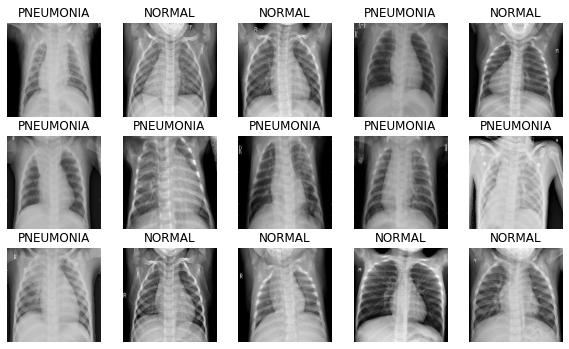

In [19]:
image_batch, label_batch = next(iter(train_ds))

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(15):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

show_batch(image_batch.numpy(), label_batch.numpy())

print("✅")

* **[iter()](https://dojang.io/mod/page/view.php?id=2408)** : 
  - 객체의 `__iter__` 메서드를 호출, 
  - 반복 가능한 객체에서 이터레이터를 반환
  - 반복을 끝낼 값을 지정하면 특정 값이 나올 때 반복을 끝냄
    - 이 경우에는 반복 가능한 객체 대신 호출 가능한 객체(callable)를 넣어줌
    - iter(호출 가능한 객체, 반복을 끝낼 값)
  
  
* **[next()](https://dojang.io/mod/page/view.php?id=2408)** : 
  - 객체의 `__next__ `메서드를 호출
  - 이터레이터에서 값을 차례대로 꺼냄
  - 기본값을 지정하면 반복이 끝나더라도 StopIteration이 발생하지 않고 기본값을 출력
    - next(반복 가능한 객체, 기본값)

## Step 4. CNN 모델링

의료영상 판독을 위해 실습에서 구현했던 model에서 다양한 것들을 바꾸어 가며 실험해볼 수 있습니다.   
**Convolution filter, 채널 개수, activation, 모델구조** 등을 다양하게 바꾸어볼 수 있습니다.

그리고, 우리는 BatchNormalization과 Dropout을 한 모델 안에서 동시에 사용하는 특이한 구성을 실습했습니다.
이것은 일반적으로 잘 사용되는 형태는 아닙니다. 하지만 이미지 사이즈가 크고 데이터가 부족한 의료영상에서는 실용적으로 간혹 좋은 성능을 보이기도 합니다. 만약 이 구성을 변경해 보면 어떤 효과가 발생하는지도 실험해 봅시다.   
* **BatchNormalization**을 쓰거나 혹은 쓰지 않거나, 
* **Dropout**을 쓰거나 혹은 쓰지 않거나 할 수 있습니다. 또, 
* **Dropout 비율**을 변경해볼 수도 있습니다.

### Separable Convolution block

In [29]:
# Separable Convolution block
def sep_conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )
    
    return block
  
print("✅")

✅


* [`tf.keras.layers.SeparableConv2D()`](https://code.i-harness.com/ko-kr/docs/tensorflow~python/tf/keras/layers/separableconv2d) : **깊이 방향 분리 가능한 2D 컨볼루션**
  - https://runebook.dev/ko/docs/tensorflow/keras/layers/separableconv2d
  - https://www.tensorflow.org/api_docs/python/tf/keras/layers/SeparableConv2D



* **[SeparableConv2D()](https://subinium.github.io/Keras-7/)** 는 Conv2D를 대체하면서 더 가볍고 더 빨라 모델의 성능을 높일 수 있는 층
  - 입력 채널별로 따로따로 공간 방향의 합성곱을 수행
  - 점별 합성곱(pointwise convolution)을 통해 출력 채널을 합침
  - 공간 특성과 채널 방향 특성을 독립적으로 인식하여 학습
  - 모델 파라미터와 연산수를 줄여줌
  - 더 빠르고 효율적인 학습을 할 수 있음
  - 제한된 데이터로 작은 모델을 처음부터 훈련시킬 때 특히 더 중요
  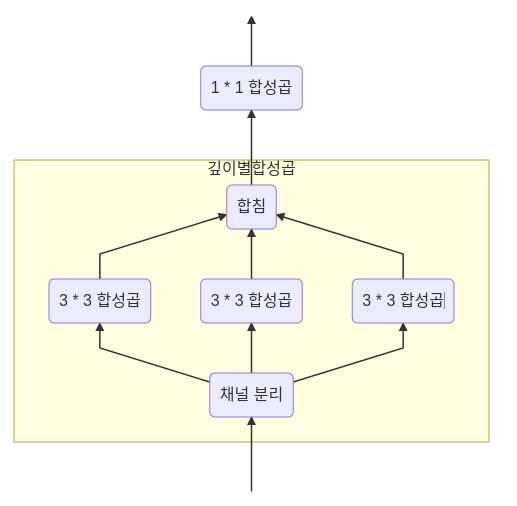

### Dense Block

In [21]:
# Dense Block
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block
  
print("✅")

✅


### CNN 모델 생성

In [103]:
# CNN 모델 생성
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same'),  # 16 --> 128
        tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same'),  # 16 --> 64
        tf.keras.layers.MaxPool2D(),
        
        sep_conv_block(32),
        sep_conv_block(64),
        tf.keras.layers.MaxPool2D(),
        
#         sep_conv_block(64),
#         sep_conv_block(128),
#         tf.keras.layers.MaxPool2D(),
#         tf.keras.layers.Dropout(0.2),
        
        sep_conv_block(128),
        sep_conv_block(256),
        tf.keras.layers.MaxPool2D(),
#         tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.5),      # 0.7 --> 0.5
        dense_block(128, 0.5),
        dense_block(64, 0.5),       # 0.3 --> 0.5
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model
  
print("✅")

✅


* Convolution filter, 채널 개수, activation, 모델구조 등을 다양하게
* BatchNormalization과 Dropout, Dropout 비율을 변경

## Step 5. 데이터 imbalance 처리

실습코드에서 데이터의 imbalance 문제에 대처하기 위해 
- 데이터 비율로 나누어진 class_weight를 설정해 주었습니다. 
- 만약 이러한 처리를 생략한다면 어떻게 될까요? 또 
- recall을 강조하기 위해 폐렴데이터를 잘 맞추는 것을 더 강화하는 효과를 만들어낼 수는 없을까요?



In [23]:
# Weight balancing
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.94
Weight for class 1: 0.67


- weight_for_0은 'Normal' 이미지에 사용할 weight를 세팅, 
- weight_for_1은 'Pneumonia' 이미지에 사용할 weight를 세팅. 
- 이 weight들은 'Normal'과 'Pneumonia' 전체 데이터 건수에 반비례하도록 설정

## Step 6. 모델 훈련

loss 함수를 변경하기는 어렵겠지만, **optimizer나 learning rate** 등의 변화를 고려해볼 수 있을 것입니다.

In [104]:
# 모델 훈련 설정
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )
    
print("✅")  

✅


**tf.keras.metrics**
* [Accuracy](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Accuracy)
* [Precision](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Precision)
* [Recall](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Recall)

In [105]:
# 모델 구조 요약
model.summary()

Model: "sequential_95"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 180, 180, 64)      1792      
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 180, 180, 128)     73856     
_________________________________________________________________
max_pooling2d_66 (MaxPooling (None, 90, 90, 128)       0         
_________________________________________________________________
sequential_88 (Sequential)   (None, 45, 45, 32)        6752      
_________________________________________________________________
sequential_89 (Sequential)   (None, 22, 22, 64)        7392      
_________________________________________________________________
max_pooling2d_69 (MaxPooling (None, 11, 11, 64)        0         
_________________________________________________________________
sequential_90 (Sequential)   (None, 5, 5, 128)       

In [ ]:
from tensorflow.keras.utils import plot_model

# plot the model
# plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True, rankdir='TB')

In [106]:
# 모델을 훈련(fit) 시키기 
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
65/65 [==============================] - 11s 165ms/step - loss: 0.5573 - accuracy: 0.6971 - precision: 0.9275 - recall: 0.6298 - val_loss: 0.8264 - val_accuracy: 0.2305 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/25
65/65 [==============================] - 10s 160ms/step - loss: 0.3779 - accuracy: 0.7788 - precision: 0.9688 - recall: 0.7362 - val_loss: 0.7768 - val_accuracy: 0.3125 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/25
65/65 [==============================] - 10s 160ms/step - loss: 0.3233 - accuracy: 0.8500 - precision: 0.9715 - recall: 0.8255 - val_loss: 0.7219 - val_accuracy: 0.2578 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/25
65/65 [==============================] - 10s 155ms/step - loss: 0.2536 - accuracy: 0.8962 - precision: 0.9777 - recall: 0.8763 - val_loss: 0.6839 - val_accuracy: 0.7500 - val_precision: 0.7500 - val_recall: 1.0000
Epoch 5/25
65/65 [==============================] - 14s 218ms/step - loss: 0

* `tf.device('/GPU:0')` : 멀티 GPU 시스템에서 하나(낮은 ID)의 GPU만 사용하기,  [참고](https://www.tensorflow.org/guide/gpu?hl=ko)


* [TensorFlow GPU 지원](https://www.tensorflow.org/install/gpu)

* [Tensorflow와 그 버전과 호환되는 CUDA, cuDNN까지 설치하는 법](https://coding-groot.tistory.com/87)

In [107]:
# 모델을 컴퓨터에 저장
model.save('my_modelB3.h5')

## Step 7. 결과 확인과 시각화

테스트데이터로 훈련된 모델을 평가해 봅시다. 우선은 accuracy를 고려해야겠지만 의료영상 모델의 특성상 recall도 중요합니다. 훈련과정의 history 그래프를 시각화해 보고, 학습 진행양상을 면밀히 분석해 보는 것도 잊지 않도록 합시다.

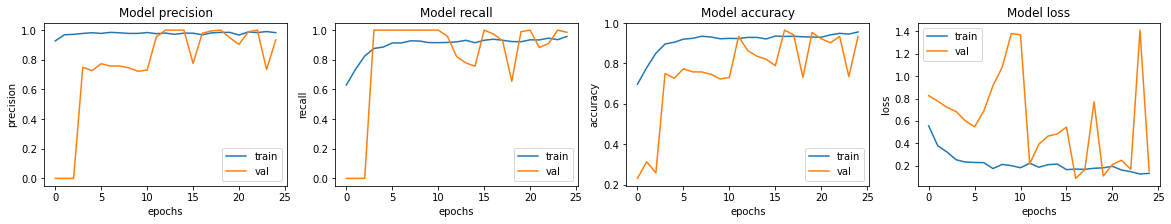

In [108]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [109]:
# 모델 평가를 위해 loss, accuracy, precision, recall 값 출력
loss, acc, prec, rec = model.evaluate(test_ds)

10/10 [==============================] - 10s 957ms/step - loss: 0.9681 - accuracy: 0.6747 - precision: 0.6587 - recall: 0.9949


## 성능개선

In [96]:
# 테스트를 위해 메모리 내의 모델을 삭제
del model 

### 좌우반전
#### Batch size, Epoch

* 조건A1 : BATCH_SIZE = 16, EPOCHS = 25, 
- loss: 0.7628 - accuracy: 0.8141 - precision: 0.7819 - recall: 0.9744
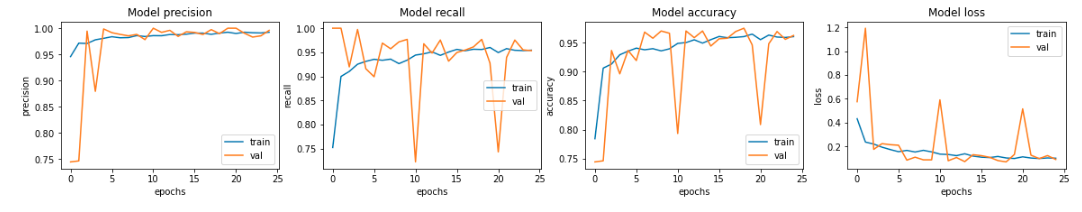
  
---
* 조건A2 : **BATCH_SIZE = 64**, EPOCHS = 25, 
- loss: 0.4608 - accuracy: 0.8365 - precision: 0.8025 - recall: 0.9795
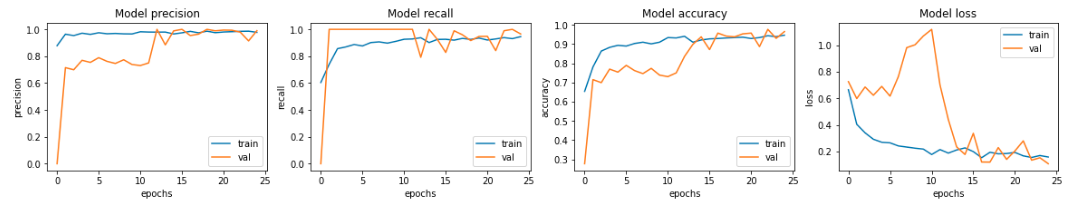
- loss: 1.0013 - accuracy: 0.7708 - precision: 0.7389 - recall: 0.9795
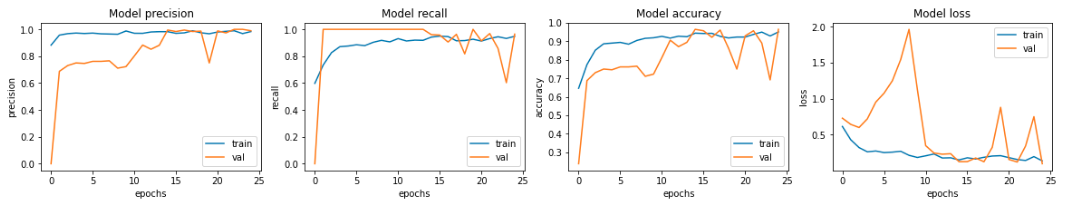

---
* 조건A3 : BATCH_SIZE = 64, **EPOCHS = 50**, 
- loss: 0.6464 - accuracy: 0.8189 - precision: 0.7798 - recall: 0.9897
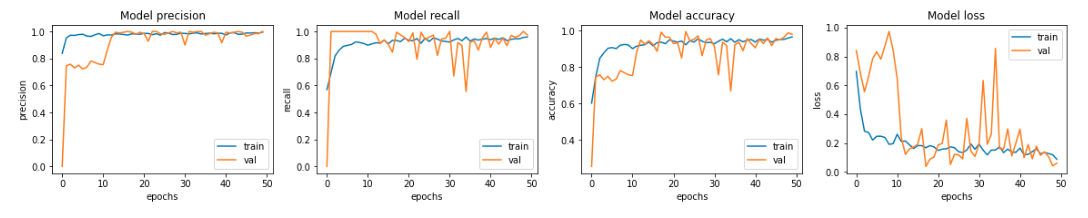
  
---
* 조건A4 : BATCH_SIZE = 64, **EPOCHS = 100**, 
- loss: 0.9697 - accuracy: 0.7853 - precision: 0.7471 - recall: 0.9923
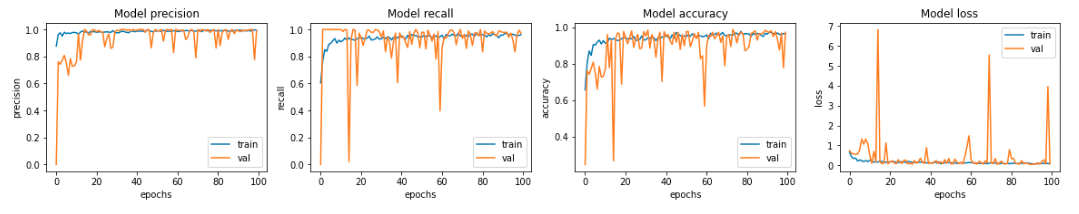

---
* 조건A5 : **BATCH_SIZE = 128**, EPOCHS = 25, 
- loss: 1.6665 - accuracy: 0.6250 - precision: 0.6250 - recall: 1.0000
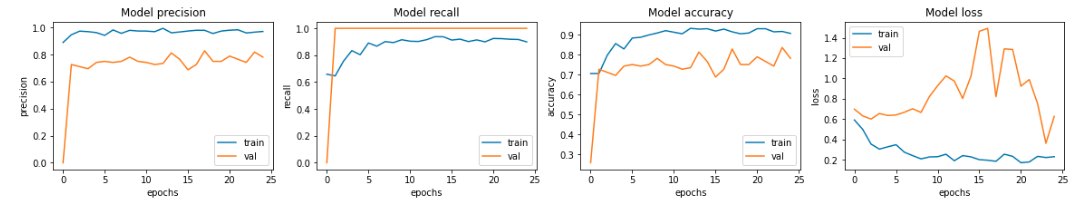

#### Convolution filter,  activation, 모델구조

조건B1 : 조건A2 + Conv2D(128)+Conv2D(64)
- loss: 0.5040 - accuracy: 0.8253 - precision: 0.7933 - recall: 0.9744
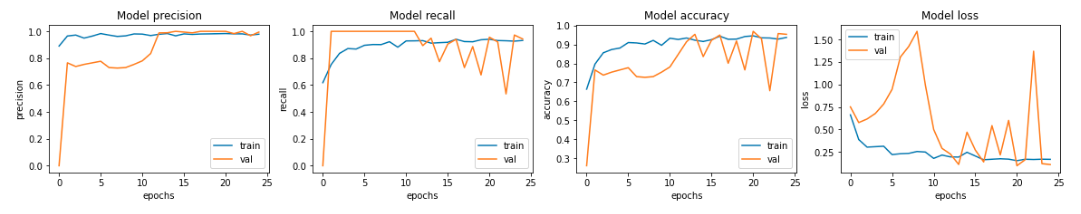

---
조건B2 : 조건A2 + Conv2D(64)+Conv2D(128)
- loss: 0.4082 - accuracy: 0.8446 - precision: 0.8496 - recall: 0.9128
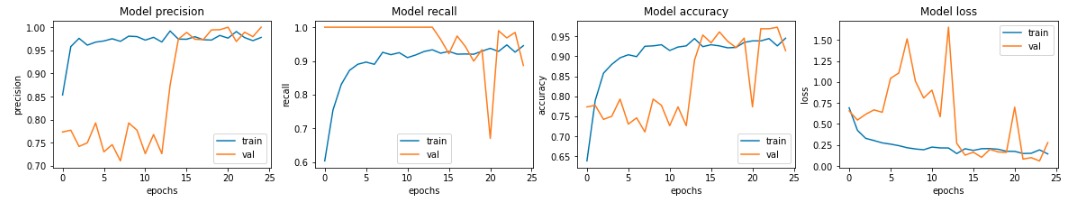

---
조건B3 : 조건A2 + Conv2D(64+128), sep_conv_block(32+64, 128+256), MaxPool2D(), Dropout(x)
- loss: 0.9681 - accuracy: 0.6747 - precision: 0.6587 - recall: 0.9949
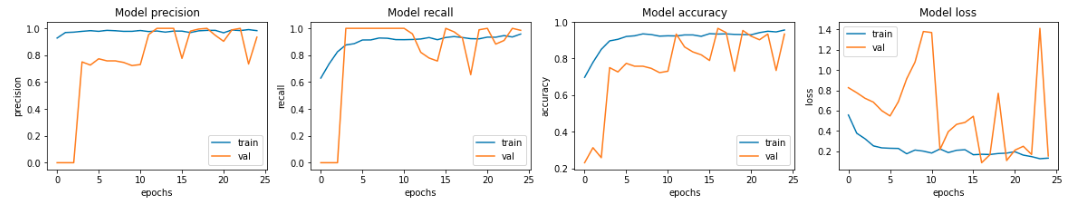

BatchNormalization, Dropout, Dropout 비율, GlobalAveragePooling2D

optimizer, learning rate 

가중치 초기화(kernel_initializer='he_normal'), 학습율(lr = 0.001) 

### 이동

###  회전

**[Confusion matrix](https://sumniya.tistory.com/26)**

<img align='center' width='40%' src='https://t1.daumcdn.net/cfile/tistory/99DC064C5BE056CE10' />  

  - **True Positive(TP)** : 실제 True인 정답을 True라고 예측 (정답)
  - **False Positive(FP)** : 실제 False인 정답을 True라고 예측 (오답)
  - **False Negative(FN)** : 실제 True인 정답을 False라고 예측 (오답)
  - **True Negative(TN)** : 실제 False인 정답을 False라고 예측 (정답)

**[분류성능평가지표](https://sumniya.tistory.com/26)**

* **accuracy(정확도)** : <span style='color:red'>전체 데이터 중에서</span> True를 True라고 예측한 것(TP)과 False를 False라고 예측한 것(TN)의 비율, $~~~~\frac{TP + TN}{ TP+FN+FP+TN}$

* **precision(정밀도)** : <span style='color:red'>모델이 True라고 분류한 것(TP+FP) 중에서</span> 실제 True인 것(TP)의 비율, $~~~~\frac{TP}{TP+FP}$

* **recall(재현율**) : <span style='color:red'>실제 True인 것(TP+FN) 중에서</span> 모델이 True라고 예측한 것(TP)의 비율, $~~~~\frac{TP}{TP+FN}$

* **F1 score** : Precision과 Recall의 조화평균, $~~~~2 \times \frac{precision ~\times ~recall}{precision ~ + ~recall}$



## 회고

* **[accuracy: 0.0000e+00 문제 발생](https://stackoverflow.com/questions/41819457/zero-accuracy-training-a-neural-network-in-keras)**
 - loss: 0.4183 - accuracy: 0.0000e+00 - precision: 0.9556 - recall: 0.7763 
 - val_loss: 0.5710 - val_accuracy: 0.0000e+00 - val_precision: 0.7520 - val_recall: 1.0000
 - 컴퓨터를 재부팅하고나서 정상적으로 accuracy 가 나왔다.

* 적은 데이터인 경우에 큰 에폭과 배치크기는 오히려 테스트 데이터의 정확도를 떨어트렸다.
